In [1]:
# ============================================
# IMPORTS
# ============================================
import pandas as pd
import numpy as np
import duckdb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# ============================================
# STEP 1: Connect to DuckDB
# ============================================
con = duckdb.connect("mimic_analysis.db")


In [3]:

# ============================================
# STEP 2: Load Patient Data (CAD + Severity)
# ============================================

df_patients = con.execute("""
    SELECT hadm_id, subject_id, anchor_age, gender, cad, severity_level
    FROM admissions_severity
    WHERE severity_level IS NOT NULL
""").df()

# Map severity to numeric classes: Merge 'No CAD' (original 0) and 'Low' (original 1) into the new class 0.
# The new class definitions are:
# 'No CAD' / 'Low' -> 0 (No/Low CAD)
# 'Moderate' -> 1 (Moderate CAD)
# 'High' -> 2 (High CAD)
severity_map = {'No CAD': 0, 'Low': 0, 'Moderate': 1, 'High': 2}
df_patients['severity_class'] = df_patients['severity_level'].map(severity_map)


In [4]:

# ============================================
# STEP 3: Define Standard Blood Test Groups
# ============================================
cbc_keywords = [
    "hemoglobin", "hematocrit", "rbc", "wbc", "platelet",
    "mcv", "mch", "mchc", "rdw", "neutrophil", "lymphocyte",
    "monocyte", "eosinophil", "basophil"
]
bmp_keywords = [
    "sodium", "potassium", "chloride", "bicarbonate", "co2",
    "urea", "bun", "creatinine", "glucose", "calcium"
]
lft_keywords = [
    "albumin", "protein", "bilirubin", "alkaline phosphatase",
    "ast", "sgot", "alt", "sgpt", "lactate"
]
lipid_keywords = [
    "cholesterol", "hdl", "ldl", "triglyceride"
]
cardiac_keywords = [
    "troponin", "ck-mb", "creatine kinase", "ck", "bnp",
    "nt-probnp", "hs-crp"
]

all_keywords = cbc_keywords + bmp_keywords + lft_keywords + lipid_keywords + cardiac_keywords
pattern = '|'.join(all_keywords)


In [5]:

# ============================================
# STEP 4: Select Blood Lab Items
# ============================================
df_labitems = con.execute("""
    SELECT itemid, label, fluid
    FROM d_labitems
    WHERE LOWER(fluid) = 'blood'
""").df()

mask = df_labitems['label'].str.lower().str.contains(pattern, na=False)
df_labitems_selected = df_labitems[mask].sort_values("label")

blood_itemids = df_labitems_selected['itemid'].tolist()
blood_itemids_str = ', '.join(map(str, blood_itemids))

print(f"Selected standard blood test count: {len(blood_itemids)}")


Selected standard blood test count: 168


In [6]:

# ============================================
# STEP 5: Load Average Blood Lab Values
# ============================================
df_labs = con.execute(f"""
    SELECT l.subject_id, d.label, AVG(l.valuenum) as mean_value
    FROM labevents l
    JOIN d_labitems d ON l.itemid = d.itemid
    WHERE l.itemid IN ({blood_itemids_str})
    GROUP BY l.subject_id, d.label
""").df()

# Pivot to wide format
df_labs_pivot = df_labs.pivot(index='subject_id', columns='label', values='mean_value').reset_index()


In [7]:

# ============================================
# STEP 6: Merge with Patient Data
# ============================================
df = pd.merge(df_patients, df_labs_pivot, on='subject_id', how='left')

# Encode gender
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

# Handle missing numeric values
df.fillna(df.select_dtypes(include=['number']).median(), inplace=True)

# Drop potential all-NaN columns
df = df.dropna(axis=1, how='all')
# ============================================
# STEP 6.5: Add Comorbidities (NEW STEP)
# ============================================
comorb_tables = {
    'diabetes': 'diabetes_adm',
    'hypertension': 'hypertension_adm',
    'renal': 'renal_adm',
    'obesity': 'obesity_icd_adm',
    'smoker': 'smokers_adm'
}

# Merge each comorbidity flag by hadm_id
for comorb, table in comorb_tables.items():
    df_comorb = con.execute(f"SELECT DISTINCT hadm_id, 1 AS {comorb} FROM {table}").df()
    
    # Coerce hadm_id types to same format
    df['hadm_id'] = df['hadm_id'].astype(str)
    df_comorb['hadm_id'] = df_comorb['hadm_id'].astype(str)
    
    # Merge on hadm_id
    df = pd.merge(df, df_comorb, on='hadm_id', how='left')
    df[comorb] = df[comorb].fillna(0).astype(int)

In [8]:

# ============================================
# STEP 7: Define Features (X) and Target (y)
# ============================================
X = df.drop(columns=['subject_id', 'hadm_id', 'cad', 'severity_level', 'severity_class'])
y = df['severity_class']

feature_names = X.columns.tolist()
print(f"Final dataset shape: {X.shape}")
print("Label distribution:\n", y.value_counts())


Final dataset shape: (540809, 99)
Label distribution:
 severity_class
0    478407
1     42081
2     20321
Name: count, dtype: int64


In [9]:

# ============================================
# STEP 8: Train-Test Split
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("\nOriginal class distribution:\n", y_train.value_counts())



Original class distribution:
 severity_class
0    382725
1     33665
2     16257
Name: count, dtype: int64


In [10]:

# ============================================
# STEP 9: Impute & Scale
# ============================================
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:

# ============================================
# STEP 10: Balance with SMOTE
# ============================================
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE class distribution:\n", pd.Series(y_train_bal).value_counts())



After SMOTE class distribution:
 severity_class
0    382725
1    382725
2    382725
Name: count, dtype: int64


In [12]:

# ============================================
# STEP 11: Hybrid Feature Selection
# ============================================

# --- (a) Mutual Information (Top 60)
mi = mutual_info_classif(X_train_bal, y_train_bal, random_state=42)
mi_df = pd.DataFrame({'feature': feature_names, 'MI': mi}).sort_values('MI', ascending=False)
top_mi_features = mi_df.head(60)['feature'].tolist()

X_train_mi = pd.DataFrame(X_train_bal, columns=feature_names)[top_mi_features]
X_test_mi = pd.DataFrame(X_test, columns=feature_names)[top_mi_features]
print(f"Selected {len(top_mi_features)} features via Mutual Information")

# --- (b) Model-Based (XGBoost)
base_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=7,
    eval_metric='mlogloss',
    random_state=42
)
base_model.fit(X_train_mi, y_train_bal)

selector = SelectFromModel(base_model, threshold="median", prefit=True)
X_train_sel = selector.transform(X_train_mi)
X_test_sel = selector.transform(X_test_mi)
selected_features = np.array(top_mi_features)[selector.get_support()]

print(f"Final selected {len(selected_features)} hybrid features")


Selected 60 features via Mutual Information


e:\Sarah's Capstone\mimic-iv-3.1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
e:\Sarah's Capstone\mimic-iv-3.1\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Final selected 30 hybrid features


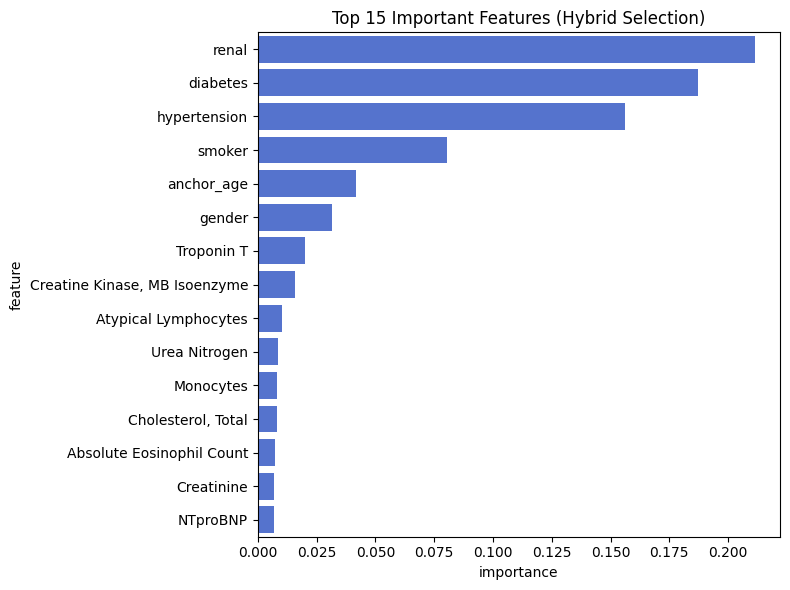

In [13]:

# ============================================
# STEP 12: Visualize Feature Importance
# ============================================
imp_df = pd.DataFrame({
    "feature": top_mi_features,
    "importance": base_model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(15), x="importance", y="feature", color='royalblue')
plt.title("Top 15 Important Features (Hybrid Selection)")
plt.tight_layout()
plt.show()


In [14]:

# ============================================
# STEP 13: Final Model Training
# ============================================
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.3,
    n_estimators=200,
    max_depth=7,
    subsample=1,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)
final_model.fit(X_train_sel, y_train_bal)

# ============================================
# STEP 14: Evaluation
# ============================================
y_pred = final_model.predict(X_test_sel)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low','Moderate','High']))




Accuracy: 0.8328

Classification Report:
              precision    recall  f1-score   support

         Low       0.97      0.84      0.90     95682
    Moderate       0.35      0.74      0.47      8416
        High       0.46      0.80      0.58      4064

    accuracy                           0.83    108162
   macro avg       0.59      0.79      0.65    108162
weighted avg       0.90      0.83      0.86    108162



In [15]:
# ============================================
# STEP 15: Save the Trained Model (NEW CELL)
import joblib
# ============================================
model_filename = 'xgb_cad_severity_model-7.joblib'
try:
    joblib.dump(final_model, model_filename)
    print(f"\nModel successfully saved to {model_filename}")
except Exception as e:
    print(f"\nError saving model: {e}")

# Save the scaler and feature names too, as they are needed for prediction
scaler_filename = 'scaler_cad_severity-7.joblib'
feature_list_filename = 'selected_features-7.joblib'

joblib.dump(scaler, scaler_filename)
joblib.dump(selected_features, feature_list_filename)
print(f"Scaler saved to {scaler_filename}")
print(f"Selected features list saved to {feature_list_filename}")


Model successfully saved to xgb_cad_severity_model-7.joblib
Scaler saved to scaler_cad_severity-7.joblib
Selected features list saved to selected_features-7.joblib


In [16]:
con.close()